## Life cycle and infinite horizon problem with value functions calculated 

In [14]:
import numpy as np
from interpolation import interp, mlinterp
from numba import njit, float64, int64, boolean
from numba.experimental import jitclass
import matplotlib.pyplot as plt
from time import time
from Utility import cal_ss_2markov,mean_preserving_spread
from copy import copy 

In [15]:
from resources_jit import MeanOneLogNormal as lognorm
from SolveLifeCycle import EGM_br

In [16]:
## plot configuration 

plt.style.use('seaborn')
plt.rcParams["font.family"] = "Times New Roman" #'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['axes.labelweight'] = 'bold'

## Set the 
plt.rc('font', size=25)
# Set the axes title font size
plt.rc('axes', titlesize=20)
# Set the axes labels font size
plt.rc('axes', labelsize=20)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=20)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=20)
# Set the legend font size
plt.rc('legend', fontsize=20)
# Set the font size of the figure title
plt.rc('figure', titlesize=20)

/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_21138/3698005312.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## The Model Class and Solver

In [17]:
lc_data = [
    ## model paras
    ('ρ', float64),              # utility parameter CRRA
    ('β', float64),              # discount factor
    ('R',float64),               # Real interest rate factor 
    ('W',float64),               # Wage rate
    ('P', float64[:, :]),        # transition probs for z_t, a persistent state  x
    ('z_val', float64[:]),       # values of z, grid values for the continuous (macro) persistent state    x
    ('sigma_psi', float64),      # permanent shock volatility              x
    ('sigma_eps', float64),      # transitory shock volatility
    ('x',float64),               # MA(1) coefficient, or essentially the autocorrelation coef of non-permanent income
    ('b_y', float64),            # loading of macro state to income        x 
    ('borrowing_cstr',boolean),  ## artificial borrowing constraint if True, natural borrowing constraint if False
    ('borrowing_cstr_value',float64), ## minimum asset grid point if borrowing constraint is True
    ('U',float64),               # the i.i.d. probability of being unemployed    * 
    ('sigma_psi_2mkv',float64[:]), # markov permanent risks, only 2 for now
    ('sigma_eps_2mkv',float64[:]), # markov transitory risk, only 2 for now
    ('init_b', float64),              ## Initial endowment (possibly from accidental bequests) 
    ('sigma_p_init',float64),         ## standard deviation of initial income
    ('T',int64),                 # years of work                          *   
    ('L',int64),                 # years of life                          * 
    ('G',float64[:]),            # growth rate of permanent income    *
    ('LivPrb',float64[:]),         # the probability of being alive next period 
    ('unemp_insurance',float64),   ## Unemployment insurance replacement ratio 
    ('pension',float64),           ## pension payment to permanent income ratio
    ('ue_markov', boolean),        ## True if 2-state emp/uemp markov 
    ('state_dependent_risk', boolean),     ## True if 2-state risks
    ('adjust_prob',float64),        ## the exogenous probability of being able to adjust consumption plan 
    ('λ', float64),                   ## Income tax rate
    ('λ_SS',float64),                 ## Social security tax 
    ('transfer', float64),            ## Transfer/current permanent income ratio
    ('bequest_ratio',float64),         ## zero: bequest thrown to the ocean; one: fully given to newborns
    ('theta',float64),           ## extrapolation parameter
    ## computational paras
    ('a_grid', float64[:]),      # Exogenous grid over savings
    ('eps_grid', float64[:]),    # Exogenous grid over transitory income shocks (for ma only)
    ('psi_shk_draws', float64[:]), ## draws of permanent income shock 
    ('eps_shk_draws', float64[:]), # draws of MA/transitory income shocks 
    ('shock_draw_size',int64),    ## nb of points drawn for shocks 
    ('psi_shk_mkv_draws',float64[:,:]),  ## 2-state markov on permanent risks 
    ('eps_shk_mkv_draws',float64[:,:]), ## 2-state markov on transitory risks
    ('init_p_draws', float64[:]),     ## Draws of initial permanent income
    ## regarding subjective beliefs
    ('P_sub',float64[:, :]),            # trans probs of belief states
    ('U2U_2mkv',float64[:]),            # state-dependent U2U prob
    ('E2E_2mkv',float64[:]),            # state-dependent E2E prob
    ('sigma_psi_true', float64),      # true permanent shock volatility              
    ('sigma_eps_true', float64),      # ture transitory shock volatility
    ('subjective',boolean),  ## belief is not necessarily equal to true 
    ('state_dependent_belief',boolean),  ## belief is state-dependent
    ('psi_shk_true_draws',float64[:]), ## draws of true permanent income shock 
    ('eps_shk_true_draws',float64[:]), ## draws of true transitory income shock 
    
    ## bequest motive 
    ('q',float64), ## q = 0 if no bequest motive 
    ('ρ_b',float64), ## elasticity of bequest 
    
    ### new value func
    ('value_func',boolean), ## boolean to decide if calculating value funcs 
]

In [18]:
@jitclass(lc_data)
class LifeCycle:
    """
    A class that stores primitives for the life cycle consumption problem.
    """

    def __init__(self,
                 ρ = 1.0,     ## relative risk aversion  
                 β = 0.99,    ## discount factor
                 P = np.array([[0.9,0.1],
                              [0.2,0.8]]),   ## transitory probability of markov state z
                 z_val = np.array([0.0,
                                   1.0]), ## markov state from low to high  
                 sigma_psi = 0.10,     ## size of permanent income shocks
                 sigma_eps = 0.10,   ## size of transitory income risks
                 x = 0.0,            ## MA(1) coefficient of non-permanent income shocks
                 borrowing_cstr = True,  ## artificial zero borrowing constraint 
                 borrowing_cstr_value = 0.0, ## artificial borrowing constraint 
                 U = 0.0,   ## unemployment risk probability (0-1)
                 LivPrb = 0.995*np.ones(60),       ## living probability 
                 b_y = 0.0,          ## loading of markov state on income  
                 R = 1.02,           ## interest factor 
                 W = 1.0,            ## Wage rate
                 T = 40,             ## work age, from 25 to 65 (including 65)
                 L = 60,             ## life length 85
                 G = np.ones(60),    ## growth factor list of permanent income 
                 shock_draw_size = 7,
                 grid_max = 5.0,
                grid_min = 0.0,
                 grid_size = 50,
                 ## subjective state dependent 
                 subjective = False,
                 state_dependent_belief = False,
                 P_sub = np.array([[0.5,0.5],
                              [0.5,0.5]]), 
                 sigma_psi_2mkv = np.array([0.05,0.2]),  ## permanent risks in 2 markov states
                 sigma_eps_2mkv = np.array([0.08,0.12]),  ## transitory risks in 2 markov states
                 U2U_2mkv = np.array([0.05,0.1]),         ## U2U in low and high risk mkv state
                 E2E_2mkv = np.array([0.95,0.9]),         ## E2E in low and high risk mkv state
                 theta = 2,               ## asymmetric extrapolation parameter
                 unemp_insurance = 0.0,   #  unemp_insurance = 0.0,   
                 pension = 1.0,           
                 ue_markov = False,    
                 state_dependent_risk = False,
                 adjust_prob = 1.0,
                 sigma_p_init = 0.01,
                 init_b = 0.0,
                 λ = 0.0,
                 λ_SS = 0.0,
                 transfer = 0.0,
                 bequest_ratio = 0.0,
                 sigma_psi_true = 0.10,     ## true size of permanent income shocks
                 sigma_eps_true = 0.10,     ## ture size of transitory income risks  
                 q = 0.0,     # no bequest by default
                 ρ_b = 1.0,
                 ####
                 value_func = False
                ): 
        self.ρ, self.β = ρ, β
        #####################
        self.q, self.ρ_b = q,ρ_b 
        ######################
        self.R = R 
        self.W = W
        self.P, self.z_val = P, z_val
        self.U = U
        #assert n_z == n_mkv, "the number of markov states for income and for risks should be equal"
        self.T,self.L = T,L
        self.G = G
        self.subjective = subjective 

        ###################################################
        ## fork depending on subjective or objective model ##
        #####################################################

        self.sigma_psi = sigma_psi
        self.sigma_eps = sigma_eps
            
        if self.subjective==False:
            self.sigma_psi_true = self.sigma_psi
            self.sigma_eps_true = self.sigma_eps
        else:
            print('reminder: needs to give true risk parameters: sigma_psi_true & sigma_eps_true!')
            self.sigma_psi_true = sigma_psi_true
            self.sigma_eps_true = sigma_eps_true
            
        self.x = x
        self.sigma_p_init = sigma_p_init
        self.init_b = init_b
        self.borrowing_cstr = borrowing_cstr
        self.borrowing_cstr_value = borrowing_cstr_value
        self.b_y = b_y
        self.λ = λ
        self.λ_SS= λ_SS
        self.transfer = transfer 
        self.bequest_ratio = bequest_ratio 
        self.sigma_psi_2mkv = sigma_psi_2mkv
        self.sigma_eps_2mkv = sigma_eps_2mkv
        self.LivPrb = LivPrb 
        self.unemp_insurance = unemp_insurance
        self.pension = pension 
        self.ue_markov = ue_markov
        self.adjust_prob = adjust_prob
        self.state_dependent_risk = state_dependent_risk
        
        ## belief 
        self.P_sub = P_sub
        self.state_dependent_belief = state_dependent_belief

            
        ## shocks 
        
        self.shock_draw_size = shock_draw_size
        self.prepare_shocks()
        
        ## saving a grid
        a_grid_regular = np.exp(np.linspace(np.log(1e-6), np.log(grid_max), grid_size-1))+grid_min
        self.a_grid = np.append(a_grid_regular,np.max(a_grid_regular)*100)
        
        ## ma(1) shock grid 
        if sigma_eps!=0.0 and x!=0.0:
            lb_sigma_ϵ = -sigma_eps**2/2-2*sigma_eps
            ub_sigma_ϵ = -sigma_eps**2/2+2*sigma_eps
            self.eps_grid = np.linspace(lb_sigma_ϵ,ub_sigma_ϵ,grid_size)
        else:
            self.eps_grid = np.array([0.0,0.001])  ## make two points for the c function to be saved correctly  

    
        ## extrapolation coefficient, i.e. higher theta, higher asymmetric response
        self.theta = theta
        
        # Test stability (not needed if it is life-cycle)
        ## this is for infinite horizon problem 
        #assert β * R < 1, "Stability condition failed."  
        
        ############
        self.value_func = value_func
        ############################
        
    ## utility function 
    def u(self,c):
        if self.ρ!=1:
            return c**(1-self.ρ)/(1-self.ρ)
        elif self.ρ==1:
            return np.log(c)
        
    def u_inv(self,u):
        if self.ρ!=1:
            return (u*(1-self.ρ))**(1/(1-self.ρ))
        elif self.ρ==1:
            return np.exp(u)
    
    # marginal utility
    def u_prime(self, c):
        return c**(-self.ρ)

    # inverse of marginal utility
    def u_prime_inv(self, c):
        return c**(-1/self.ρ)
    
    #########################
    ## transfer func for v func
    #####
    
    def vTransf(self,v):
        # inverse transform v function after linear interporlation\n",
        return self.u_inv(v)
    
    def vUntransf(self,m):
        # inverse transform v function after linear interporlation\n",
        return self.u(m)
    
    ## a function for the transitory/persistent income component
    ### the fork depending on if discrete-markov bool is on/off
    def Y(self, z, u_shk):
        #from the transitory/ma shock and ue realization  to the income factor
        if self.ue_markov ==False:
            ## z state continuously loading to income
            ## u_shk here represents the cumulated MA shock, for instance, for ma(1), u_shk = phi eps_(t-1) + eps_t
            ## income 
            return np.exp(u_shk + (z * self.b_y))
        elif self.ue_markov ==True:
            ## ump if z ==0 and emp if z==1
            assert len(self.P)==2,"unemployment/employment markov has to be 2 state markov"
            return (z==0)*(self.unemp_insurance) + (z==1)*np.exp(u_shk)
        
    # a function from the log permanent shock to the income factor
    def Γ(self,psi_shk):
        return np.exp(psi_shk)
    
    def prepare_shocks(self):
        subjective = self.subjective
        shock_draw_size = self.shock_draw_size
        sigma_psi = self.sigma_psi
        sigma_eps = self.sigma_eps
        sigma_psi_true = self.sigma_psi_true
        sigma_eps_true = self.sigma_eps_true
        sigma_p_init = self.sigma_p_init
        sigma_psi_2mkv = self.sigma_psi_2mkv
        sigma_eps_2mkv = self.sigma_eps_2mkv
        
        ##################################################################
         ## discretized distributions 
        ##################################################################
                
        psi_shk_dist = lognorm(sigma_psi,100000,shock_draw_size)
        self.psi_shk_draws = np.log(psi_shk_dist.X)  ## the discretized is lognormal variable itself, we work with the log of it
        eps_shk_dist = lognorm(sigma_eps,100000,shock_draw_size)
        self.eps_shk_draws = np.log(eps_shk_dist.X)
        
        ## the draws used for simulation in household block 
        if subjective==False:
            self.psi_shk_true_draws =  self.psi_shk_draws
            self.eps_shk_true_draws =  self.eps_shk_draws
        else:
            psi_shk_true_dist = lognorm(sigma_psi_true,100000,shock_draw_size)
            eps_shk_true_dist = lognorm(sigma_eps_true,100000,shock_draw_size)
            self.psi_shk_true_draws =  np.log(psi_shk_true_dist.X)
            self.eps_shk_true_draws =  np.log(eps_shk_true_dist.X)
            
        
        init_p_dist = lognorm(sigma_p_init,100000,shock_draw_size)
        self.init_p_draws = np.log(init_p_dist.X)
        
        ## draw shocks for various markov state of volatility 
        #sigma_psi_2mkv_r = sigma_psi_2mkv.reshape(n_mkv,-1)
        #sigma_eps_2mkv_r = sigma_eps_2mkv.reshape(n_mkv,-1)
        
        sigma_psi_2mkv_l = lognorm(sigma_psi_2mkv[0],100000,shock_draw_size)
        sigma_psi_2mkv_h = lognorm(sigma_psi_2mkv[1],100000,shock_draw_size)
        
        self.psi_shk_mkv_draws = np.stack((np.log(sigma_psi_2mkv_l.X),
                                         np.log(sigma_psi_2mkv_h.X)))
        
        sigma_eps_2mkv_l = lognorm(sigma_eps_2mkv[0],100000,shock_draw_size)
        sigma_eps_2mkv_h = lognorm(sigma_eps_2mkv[1],100000,shock_draw_size)
        
        self.eps_shk_mkv_draws = np.stack((np.log(sigma_eps_2mkv_l.X),
                                         np.log(sigma_eps_2mkv_h.X)))
        
    def terminal_solution(self):
        
        ## depending on if bequest 
        
        k = len(self.a_grid)
        k2 =len(self.eps_grid)
        n = len(self.P)
        σ_init = np.empty((k,k2,n))
        m_init = np.empty((k,k2,n))
        ################################
        v_init = np.empty((k,k2,n))
        ###############################
        a_grid_positive = self.a_grid - self.a_grid[0] 

        if self.q ==0.0:
            for z in range(n):
                for j in range(k2):
                    m_init[:,j,z] = a_grid_positive
                    σ_init[:,j,z] = m_init[:,j,z]
                    if self.value_func:
                        v_init[:,j,z] = self.u(m_init[:,j,z])
        else:
            for z in range(n):
                for j in range(k2):
                    σ_init[:,j,z] = (a_grid_positive**(-self.ρ_b))**(-1/self.ρ)
                    m_init[:,j,z] = a_grid_positive + σ_init[:,j,z]
                    if self.value_func:
                        v_init[:,j,z] = self.u(σ_init[:,j,z])+self.q*self.u(m_init[:,j,z]-σ_init[:,j,z])
        return m_init,σ_init,v_init

In [19]:
## this extends EGM_combine to calculate value function 

@njit
def EGM_vfunc(mϵ_in, 
           σ_in, 
           v_in, 
           age_id,
           lc):
    """
    The backward iterating operator for the life-cycle consumption problem,
    using the endogenous grid method. Calculates value functions over grids if lc.value_func is True.

        * lc is an instance of life cycle model
        * σ_in is a n1 x n2 x n3 dimension consumption policy 
          * n1 = dim(s), n2 = dim(eps), n3 = dim(z)
        * mϵ_in is the same sized grid points of the three state variable 
        * mϵ_in[:,j,z] is the vector of wealth grids corresponding to j-th grid of eps and z-th grid of z 
        * σ_in[i,j,z] is consumption at mϵ_in[i,j,z]
    """    
    # Simplify names
    u_func = lc.u
    u_prime, u_prime_inv = lc.u_prime, lc.u_prime_inv
    vTransf,vUntransf = lc.vTransf,lc.vUntransf
    ρ, β = lc.ρ, lc.β
    R = lc.R

    ## markov state
    P = lc.P
    W = lc.W
    z_val = lc.z_val
    a_grid,eps_grid = lc.a_grid,lc.eps_grid
    psi_shk_draws, eps_shk_draws= lc.psi_shk_draws, lc.eps_shk_draws
    psi_shk_mkv_draws, eps_shk_mkv_draws = lc.psi_shk_mkv_draws, lc.eps_shk_mkv_draws
    borrowing_cstr = lc.borrowing_cstr 
    borrowing_cstr_value = lc.borrowing_cstr_value
    ue_prob = lc.U  ## uemp prob
    unemp_insurance = lc.unemp_insurance
    adjust_prob = lc.adjust_prob  ## exogenous adjustment probability
    Y = lc.Y
    ####################
    Γ = lc.Γ
    ####################################
    G = lc.G[age_id+1]  ## get the age specific growth rate, G[T] is the sudden drop in retirement from working age
    LivProb = lc.LivPrb[age_id+1]  ## live probabilities
    ####################################

        
    x = lc.x
    λ = lc.λ
    λ_SS = lc.λ_SS
    transfer = lc.transfer
    pension = lc.pension
    ###################
    
    n = len(P)

    # Create consumption functions by linear interpolation
    ########################################################
    σ = lambda m,ϵ,z: mlinterp((mϵ_in[:,0,z],eps_grid),σ_in[:,:,z], (m,ϵ)) 
    
    #########################################################
    ## Create value functions by two-step interpolation 
    #########################################################
    ## (interpolate over transfored value function and inverse the transformation)
    
    if lc.value_func:
        v_tfunc_in = lambda m,ϵ,z: mlinterp((mϵ_in[:,0,z],
                                             eps_grid),
                                            vTransf(v_in[:,:,z]), 
                                            (m,ϵ)) 
        v_func_in  = lambda m,ϵ,z: vUntransf(v_tfunc_in(m,ϵ,z))
    
    # Allocate memory
    σ_out = np.empty_like(σ_in)
    v_out = np.empty_like(v_in)

    ############################################################################
    ## repeat the following chunk for each discrete choice: adjust versus non-adjust
    ### the policy next period will be useful to compute marginal utilities 
    ##########################################################################
    
    # Obtain c_i at each a_i, z, store in σ_out[i, z], computing
    # the expectation term by computed by averaging over discretized equally probable points of the distributions
    for i, a in enumerate(a_grid):
        for j, eps in enumerate(eps_grid):
            for z in range(n):
                # Compute expectation
                Ez = 0.0
                Ev = 0.0
                for z_hat in range(n):
                    z_val_hat = z_val[z_hat]
                    ########################################
                    if lc.state_dependent_risk == False:
                        pass
                    else:
                        psi_shk_draws = psi_shk_mkv_draws[z_hat,:]
                        eps_shk_draws = eps_shk_mkv_draws[z_hat,:]
                    ########################################
                    for eps_shk in eps_shk_draws:
                        for psi_shk in psi_shk_draws:
                            ## for employed next period 
                            Γ_hat = Γ(psi_shk) 
                            u_shk = x*eps+eps_shk
                            age = age_id + 1
                            if age <=lc.T-1:   #till say 39, because consumption policy for t=40 changes   
                                ## work 
                                Y_hat = (1-λ)*(1-λ_SS)*Y(z_val_hat,u_shk) ## conditional on being employed
                                c_hat_adj = σ(R/(G*Γ_hat) * a + Y_hat+transfer,eps_shk,z_hat)
                                c_hat = c_hat_adj
                                    
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)
                                value = v_func_in(R/(G*Γ_hat) * a + Y_hat+transfer,eps_shk,z_hat)

                                ## for unemployed next period
                                Y_hat_u = (1-λ)*unemp_insurance
                                
                                c_hat_adj_u = σ(R/(G*Γ_hat) * a + Y_hat_u+transfer,eps_shk,z_hat)
                                c_hat_u = c_hat_adj_u ## conditional on non-adjusting next period
                                utility_u = (G*Γ_hat)**(1-ρ)*u_prime(c_hat_u)
                            
                                Ez += LivProb*((1-ue_prob)*utility * P[z, z_hat]+
                                           ue_prob*utility_u* P[z, z_hat]
                                          )
                                if lc.value_func:
                                    value_u = v_func_in(R/(G*Γ_hat) * a + Y_hat_u+transfer,eps_shk,z_hat)

                                    Ev += LivProb*((1-ue_prob)*value * P[z, z_hat]+
                                               ue_prob*value_u* P[z, z_hat]
                                              )
                            else:
                                ## retirement
                                Y_R = pension
                                ## no income shocks affecting individuals
                                Γ_hat = 1.0 
                                eps_shk = 0.0
                                c_hat_adj = σ(R/(G*Γ_hat) * a + (Y_R+transfer),eps_shk,z_hat)
                                c_hat = c_hat_adj ## conditional on non-adjusting next period
                                    
                                utility = (G*Γ_hat)**(1-ρ)*u_prime(c_hat)
                                Ez += LivProb*utility * P[z, z_hat]
                                if lc.value_func:
                                    value = v_func_in(R/(G*Γ_hat) * a + Y_R+transfer,eps_shk,z_hat)
                                    Ev += LivProb*value* P[z, z_hat]
                            
                Ez = Ez / (len(psi_shk_draws)*len(eps_shk_draws))
                if lc.value_func:
                    Ev = Ev / (len(psi_shk_draws)*len(eps_shk_draws))

                ## the last step depends on if adjustment is fully flexible
                ## the two cases can collapse into one formula, but I keep them separately.
                if adjust_prob ==1.0:
                    σ_out[i, j, z] =  u_prime_inv(β * R* Ez)
                elif adjust_prob <1.0:
                    σ_out[i, j, z] =  u_prime_inv(β * R*adjust_prob/(1-β*R*(1-adjust_prob))* Ez)
                    ## need to check if LivProb should be in the denominator
                    
                ## value func 
                if lc.value_func:
                    v_out[i,j,z] = u_func(σ_out[i, j, z])+β*LivProb*Ev
                else:
                    v_out = None
                    
    # Calculate endogenous asset grid
    mϵ_out = np.empty_like(σ_out)

    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            mϵ_out[:,j,z] = a_grid + σ_out[:,j,z]

    # Fixing a consumption-asset pair at for the constraint region
    for j,ϵ in enumerate(eps_grid):
        for z in range(n):
            ### anchor the value at the borrowing constraint to be negative infinity 
            #####################
            v_out[0,j,z] = - 1e+10
            ######################
            ## get the natural borrowing constraint 
            if age <=lc.T-1:
                ## the lowest transitory draw at state z  
                if lc.state_dependent_belief:
                    self_min_a = - np.exp(np.min(eps_shk_mkv_draws[z,:]))*G/R 
                else:
                    self_min_a = - np.exp(np.min(eps_shk_draws))*G/R
                    self_min_a = max(self_min_a,-unemp_insurance/R)
            else:
                self_min_a = - pension*G/R
            
            if borrowing_cstr==True:  ## either hard constraint is zero or positive probability of losing job
                σ_out[0,j,z] = 0.0
                mϵ_out[0,j,z] = max(self_min_a,borrowing_cstr_value)
            else: 
                σ_out[0,j,z] = 0.0 
                mϵ_out[0,j,z] = self_min_a
            assert mϵ_out[0,j,z] < a_grid[0], "a grid goes below the borrowing constraint, make a_min bigger"
                        
    return mϵ_out, σ_out, v_out

In [20]:
## for life-cycle/finite horizon problem 
def solve_model_backward_iter_vfunc(model,        # Class with model information
                              mϵ_vec,        # Initial condition for assets and MA shocks
                              σ_vec,        # Initial condition for consumption
                              v_vec,
                              br = False):

    ## memories for life-cycle solutions 
    n_grids1 = σ_vec.shape[0]
    n_grids2 = σ_vec.shape[1]
    n_z = len(model.P)                       
    mϵs_new =  np.empty((model.L,n_grids1,n_grids2,n_z),dtype = np.float64)
    σs_new =  np.empty((model.L,n_grids1,n_grids2,n_z),dtype = np.float64)
    vs_new = np.empty((model.L,n_grids1,n_grids2,n_z),dtype = np.float64)
    
    mϵs_new[0,:,:,:] = mϵ_vec
    σs_new[0,:,:,:] = σ_vec
    if model.value_func:
        vs_new[0,:,:,:] = v_vec
    
    for year2L in range(1,model.L): ## nb of years till L from 0 to Model.L-2
        age = model.L-year2L
        age_id = age-1
        #print("at work age of "+str(age))
        if model.value_func:
            mϵ_vec_next, σ_vec_next,v_vec_next = mϵs_new[year2L-1,:,:,:],σs_new[year2L-1,:,:,:],vs_new[year2L-1,:,:,:]
        else:
            mϵ_vec_next, σ_vec_next,v_vec_next = mϵs_new[year2L-1,:,:,:],σs_new[year2L-1,:,:,:],None
        if br==False:
            mϵ_new, σ_new,v_new = EGM_vfunc(mϵ_vec_next, σ_vec_next, v_vec_next,age_id, model)
        elif br==True:
            #print('subjective model with stochastic risk')
            mϵ_new, σ_new = EGM_br(mϵ_vec_next, σ_vec_next, age_id, model)
        mϵs_new[year2L,:,:,:] = mϵ_new
        σs_new[year2L,:,:,:] = σ_new
        vs_new[year2L,:,:,:] = v_new
    return mϵs_new, σs_new, vs_new

In [21]:
## for infinite horizon problem 
def solve_model_iter_vfunc(model,        # Class with model information
                         me_vec,        # Initial condition for assets and MA shocks
                         σ_vec,        # Initial condition for consumption
                         v_vec,
                      tol=1e-6,
                      max_iter=2000,
                      verbose=True,
                      print_skip=50,
                      br = False):

    # Set up loop
    i = 0
    error = tol + 1
    
    ## memories for life-cycle solutions
    while i < max_iter and error > tol:
        if br==False:
                me_new, σ_new,v_new = EGM_vfunc(me_vec, σ_vec, v_vec,0,model)
        elif br==True:
            #print('subjective model with stochastic risk')
            mϵ_new, σ_new = EGM_br(me_vec, σ_vec, 0, model)

        error = np.max(np.abs(σ_vec - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        me_vec, σ_vec, v_vec = np.copy(me_new), np.copy(σ_new), np.copy(v_new)

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return me_vec, σ_vec, v_vec

## Initialize the model

In [22]:
if __name__ == "__main__":


    ## parameters 
    ###################

    U = 0.2 ## transitory ue risk
    U0 = 0.0 ## transitory ue risk

    ## life cycle 

    T = 40
    L = 60
    G = np.ones(L)
    YPath = np.cumprod(G)

## Life-Cycle Problem 

In [23]:
if __name__ == "__main__":
    lc_paras = {'sigma_psi':0.15, # permanent 
                'sigma_eps': 0.03, #transitory
                'U':U,
                'ρ':2,
                'R':1.01,
                'T':T,
                'L':L,
                'G':G,
                'β':0.97,
                'x':0.0,  # no MA shock 
                'borrowing_cstr':True,
                'b_y':0.0, #no persistent state
                'unemp_insurance':0.15,
                'grid_size':100,
                'value_func':True,
               }

In [24]:
if __name__ == "__main__":
    lc = LifeCycle(**lc_paras)

### Consumption  the last period 

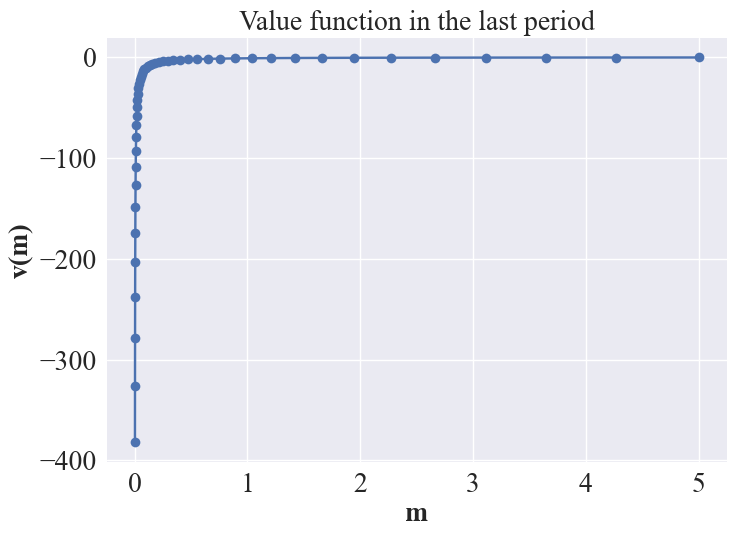

In [25]:
# Initial the end-of-period consumption policy of σ = consume all assets

if __name__ == "__main__":

    ## initial consumption functions 
    
    m_init,σ_init,v_init = lc.terminal_solution()
    plt.title('Value function in the last period')
    plt.plot(m_init[int(m_init.shape[0]/2):-1,1,1],
             v_init[int(m_init.shape[0]/2):-1,1,1],
            'o-')
    plt.xlabel('m')
    plt.ylabel('v(m)')

In [26]:
if __name__ == "__main__":

    t_start = time()

    ### this line is very important!!!!
    #### need to regenerate shock draws for new sigmas
    lc.prepare_shocks()

    ## terminal solution
    m_init,σ_init,v_init = lc.terminal_solution()

    ## solve backward
    ms_star_basic, σs_star_basic,vs_star_basic = solve_model_backward_iter_vfunc(lc,
                                                                         m_init,
                                                                         σ_init,
                                                                         v_init)

    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_21138/1625708348.py:68: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected. This is deprecated behaviour that will be removed in Numba 0.59.0.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "../../../../opt/anaconda3/lib/python3.8/site-packages/interpolation/multilinear/mlinterp.py", line 48:

        def mlininterp(grid: Tuple, c: Array, u: Tuple) -> float:
        ^

  v_tfunc_in = lambda m,ϵ,z: mlinterp((mϵ_in[:,0,z],
/var/folders/39/ks6jc__9375c2fl7h7pwq5jh0000gn/T/ipykernel_21138/1625708348.py:68: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/re

Time taken, in seconds: 19.172552824020386


### Different permanent/transitory risk (no MA)

In [27]:
if __name__ == "__main__":
    lc_pt_paras = copy(lc_paras)
    
    lc_pt = LifeCycle(**lc_pt_paras)

In [28]:
if __name__ == "__main__":

    t_start = time()

    sigma_psi_ls = [0.03,0.2]
    sigma_eps_ls = [0.03,0.2]
    
    ms_stars =[]
    σs_stars = []
    vs_stars = []
    
    for i,sigma_psi in enumerate(sigma_psi_ls):
        lc_pt.sigma_psi = sigma_psi
        lc_pt.sigma_eps = sigma_eps_ls[i]
        ### this line is very important!!!!
        #### need to regenerate shock draws for new sigmas
        lc_pt.prepare_shocks()
        
        ## terminal solution
        m_init,σ_init,v_init = lc_pt.terminal_solution()
        
        ## solve backward
        ms_star, σs_star,vs_star = solve_model_backward_iter_vfunc(lc_pt,
                                                                     m_init,
                                                                     0.5*σ_init,
                                                                     v_init)
        ms_stars.append(ms_star)
        σs_stars.append(σs_star)
        vs_stars.append(vs_star)

    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))

Time taken, in seconds: 33.39372181892395


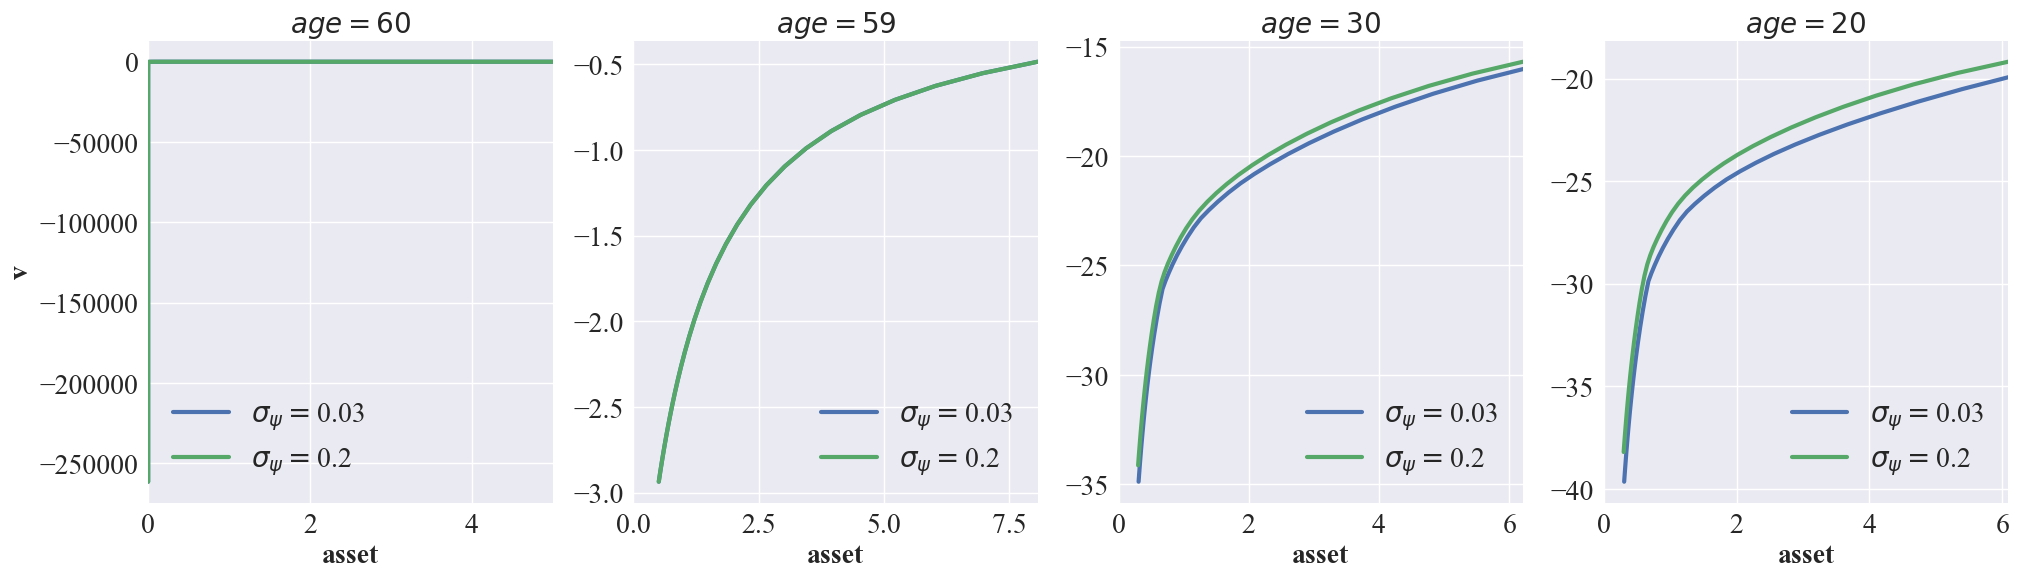

In [29]:
if __name__ == "__main__":


    ## plot c func at different age /asset grid
    years_left = [0,1,30,40]
    start_m_at = 10
    
    n_sub = len(years_left)

    eps_fix = 0 ## the first eps grid 

    fig,axes = plt.subplots(1,n_sub,figsize=(6*n_sub,6))

    for x,year in enumerate(years_left):
        age = lc_pt.L-year
        i = lc_pt.L-age
        for k,sigma_psi in enumerate(sigma_psi_ls):
            m_plt,v_plt = ms_stars[k][i,start_m_at:-1,eps_fix,0],vs_stars[k][i,start_m_at:-1,eps_fix,0]
            axes[x].plot(m_plt,
                         v_plt,
                         label = r'$\sigma_\psi=$'+str(sigma_psi),
                         lw=3,
                        )
        axes[x].legend()
        axes[x].set_xlim(0.0,np.max(m_plt))
        axes[x].set_xlabel('asset')
        axes[0].set_ylabel('v')
        axes[x].set_title(r'$age={}$'.format(age))

In [30]:
## the size of value function is  T x nb_a x nb_eps x nb_z 
if __name__ == "__main__":
    print(vs_star.shape)

(60, 100, 2, 2)


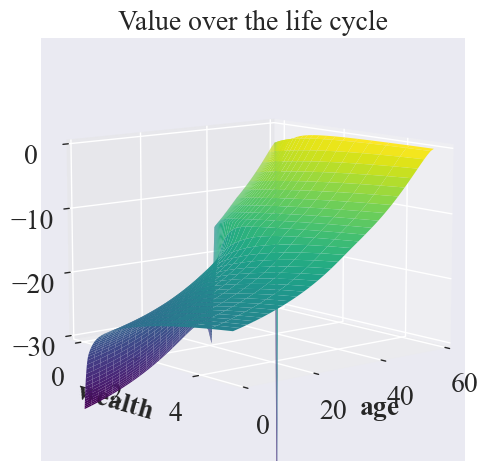

In [31]:
if __name__ == "__main__":

    ## plot 3d functions over life cycle 
    start_m_at = 60
    
    ages = np.array(range(ms_star.shape[0]))
    asset = ms_star[0,start_m_at:-1,0,0]
    xx, yy = np.meshgrid(ages, asset)
    v_stars = np.flip(vs_star[:,start_m_at:-1,0,0],axis=0).T

    fig = plt.figure()
    ax = fig.add_subplot(111, 
                         projection='3d')
    dem3d = ax.plot_surface(xx,
                            yy,
                            v_stars,
                            cmap="viridis"
                           )
    ax.set_xlim(60,0)
    ax.set_title('Value over the life cycle')
    ax.set_xlabel('age')
    ax.set_ylabel('wealth')
    ax.view_init(10, 50)
    ax.set_zlim(-30,0)

## Infinite horizon problem

Error at iteration 50 is 0.17736520495456531.
Error at iteration 100 is 0.02854205076544325.
Error at iteration 150 is 0.0065943487881057194.
Error at iteration 200 is 0.0016473703728188127.
Error at iteration 250 is 0.00041954015535417.
Error at iteration 300 is 0.00010736911189823672.
Error at iteration 350 is 2.7512387211103828e-05.
Error at iteration 400 is 7.052065461365942e-06.
Error at iteration 450 is 1.8077570231866957e-06.

Converged in 472 iterations.
Time taken, in seconds: 151.73980164527893


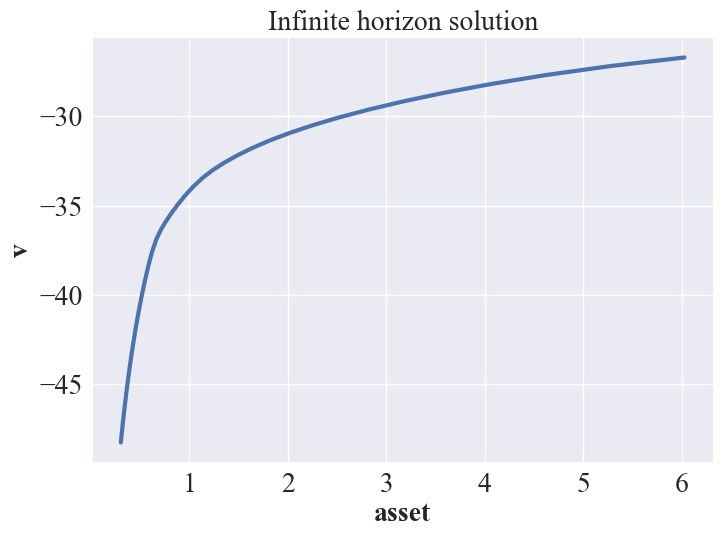

In [32]:
if __name__ == "__main__":
    
    inf_liv_paras = copy(lc_paras)
    
    
    ## initialize a model instance

    inf_liv = LifeCycle(**inf_liv_paras)


    ## initial guess of consumption functions 

    m_init,σ_init,v_init = inf_liv.terminal_solution()
   

    t_start = time()


    m_inf_star, σ_inf_star,v_inf_star = solve_model_iter_vfunc(inf_liv,
                                                              m_init,
                                                              σ_init,
                                                              v_init)

    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))   


    ## plot v func 

    eps_fix = 0

    plt.plot(m_inf_star[1:-1,eps_fix,0],
             v_inf_star[1:-1,eps_fix,0],
             lw=3
            )
    plt.xlabel('asset')
    plt.ylabel('v')
    plt.title('Infinite horizon solution')

## Infinite horizon with adjustment inertia



Error at iteration 50 is 0.08929473157076018.
Error at iteration 100 is 0.002866791928255452.
Error at iteration 150 is 9.853614026411606e-05.
Error at iteration 200 is 3.3946635795700786e-06.

Converged in 219 iterations.
Time taken, in seconds: 70.29364085197449


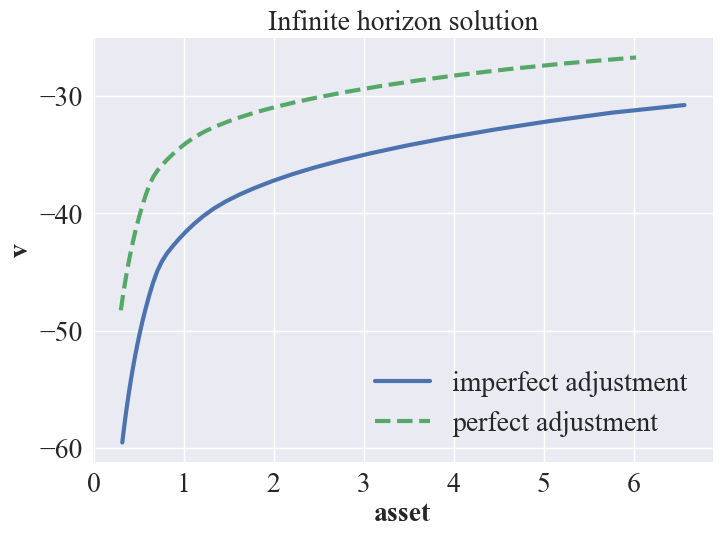

In [33]:
if __name__ == "__main__":


    ## Initialize a model instance
    imp_adjust_paras = copy(lc_paras)
    imp_adjust_paras['adjust_prob'] = 0.2
    
    imp_adjust = LifeCycle(**imp_adjust_paras)

    ## initial consumption functions 
    m_init,σ_init,v_init = imp_adjust.terminal_solution()

    t_start = time()


    ## set different ma parameters 
    m_imp_star, σ_imp_star, v_imp_star = solve_model_iter_vfunc(imp_adjust,
                                                              m_init,
                                                              σ_init,
                                                              v_init)


    t_finish = time()

    print("Time taken, in seconds: "+ str(t_finish - t_start))   


    ## plot c func at different age /asset grid

    eps_fix = 0

    plt.plot(m_imp_star[1:-1,eps_fix,1],
             v_imp_star[1:-1,eps_fix,1],
             '-',
             label = 'imperfect adjustment',
             lw=3
            )
    plt.plot(m_inf_star[1:-1,eps_fix,1],
             v_inf_star[1:-1,eps_fix,1],
             '--',
             label = 'perfect adjustment',
             lw=3
            )
    plt.legend()
    plt.xlabel('asset')
    plt.ylabel('v')
    plt.title('Infinite horizon solution')